In [26]:
from format_data import format_2D
from models import Autoencoder, train_model, Transformer, SmallAutoencoder
from torch.optim import Adam
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np 
from data_analysis import plot_property_distribution, plot_property_distribution2
# from torchsummary import summary
from torchinfo import summary
import torch
import constants as c
import pandas as pd 
from model_analysis import plot_loss, plot_anomaly_score, plot_roc
import glob 
import os

In [27]:
background_label = "qcd400to500"
signal_label = "wjet400to500"
# background_label = "background"
# hbb_label = "hbb"
props = ['pdgId']
data_dir = "/isilon/data/users/jpfeife2/AutoEncoder-Anomaly-Detection/processed_data"

batch_size = 20
epochs = 8
initial_lr = 0.001
weight_decay = 1e-3
latent_dim = 12

n_props = len(props)
prop_string = ''.join(['_' + str(prop) for prop in props])

In [28]:
pkl_files = glob.glob(os.path.join(data_dir, f'*{background_label}*.pkl'))
background_file = pd.concat([pd.read_pickle(file) for file in pkl_files], ignore_index=True)[:1000]

pkl_files = glob.glob(os.path.join(data_dir, f'*{signal_label}*.pkl'))
signal_file = pd.concat([pd.read_pickle(file) for file in pkl_files], ignore_index=True)[:1000]

pkl_files = glob.glob(os.path.join(data_dir, f'*{"hbb400to500"}*.pkl'))
hbb_file = pd.concat([pd.read_pickle(file) for file in pkl_files], ignore_index=True)[:1000]
print("FILES LOADED")

FILES LOADED


In [29]:
background, scalers, background_data = format_2D(background_file, properties=props, scalers=None)
np.save(data_dir + "/" + background_label + prop_string + ".npy", background)
print("BACKGROUND LOADED AND SAVED")

signal, _, signal_data = format_2D(signal_file, properties=props, scalers=scalers)
np.save(data_dir + "/" + signal_label + prop_string + ".npy", signal)
print("SIGNAL LOADED AND SAVED")

hbb, _, hbb_data = format_2D(hbb_file, properties=props, scalers=scalers)
np.save(data_dir + "/" + 'hbb400to500' + prop_string + ".npy", hbb)
print("HBB LOADED AND SAVED")

[-211, -13, -11, 11, 13, 22, 130, 211]
{-211: 1, -13: 2, -11: 3, 11: 4, 13: 5, 22: 6, 130: 7, 211: 8}
Length of data:  1000
BACKGROUND LOADED AND SAVED
[-211, -13, -11, 11, 13, 22, 130, 211]
{-211: 1, -13: 2, -11: 3, 11: 4, 13: 5, 22: 6, 130: 7, 211: 8}
Length of data:  1000
SIGNAL LOADED AND SAVED
[-211, -13, -11, 11, 13, 22, 130, 211]
{-211: 1, -13: 2, -11: 3, 11: 4, 13: 5, 22: 6, 130: 7, 211: 8}
Length of data:  1000
HBB LOADED AND SAVED


In [30]:
print(len(background_data))
print(len(signal_data))
print(len(hbb_data))

1
1
1


In [31]:
background_data = [x for sublist in background_data for x in sublist]
signal_data = [x for sublist in signal_data for x in sublist]
hbb_data = [x for sublist in hbb_data for x in sublist]

In [32]:
background_cuts = [x for x in background_data if x in [2, 3, 4, 5]]
signal_cuts = [x for x in signal_data if x in [2, 3, 4, 5]]
hbb_cuts = [x for x in hbb_data if x in [2, 3, 4, 5]]

In [33]:
print(len(background_data))
print(len(signal_data))
print(len(hbb_data))

36261
34959
39491


In [34]:
print(len(signal_cuts)/len(signal_data))
print(len(background_cuts)/len(background_data))
print(len(hbb_cuts)/len(hbb_data))

0.004605394891158214
0.003833319544414109
0.006077334076118609


In [35]:
prop_name = 'pdgId == [-13, -11, 11, 13]'

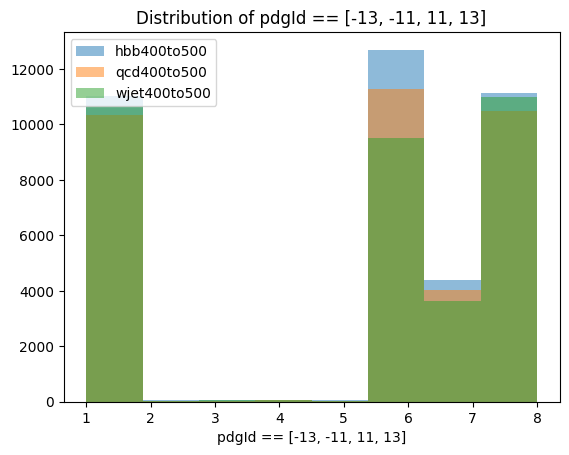

In [39]:
fig, ax = plt.subplots()
ax.set_title("Distribution of " + prop_name )
ax.set_xlabel(prop_name)

bins = 8
ax.hist(hbb_data, density=False, label='hbb400to500', alpha=0.5, bins=bins)
ax.hist(background_data, density=False, label=background_label, alpha=0.5, bins=bins)
ax.hist(signal_data, density=False, label=signal_label, alpha=0.5, bins=bins)

plt.legend()
plt.savefig("plots/" + prop_name + "_distribution.png")
plt.show()

In [17]:
prop_name = "pdgId"
background_cuts = background_data 
signal_cuts = signal_data 
hbb_cuts = hbb_data

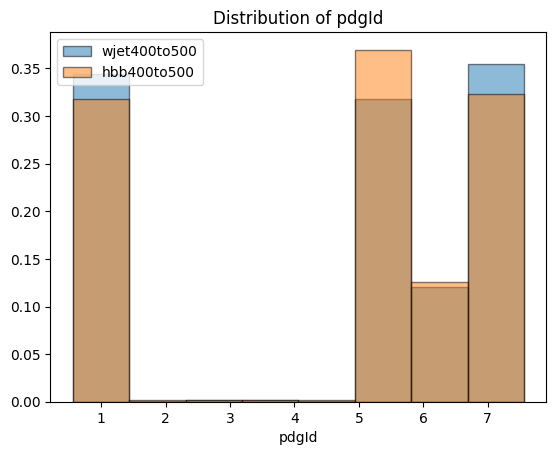

In [19]:
fig, ax = plt.subplots()
ax.set_title("Distribution of " + prop_name)
ax.set_xlabel(prop_name)
bins = 8

def plot_hist(data, label, alpha, bins, desired_density, ax):
    # Compute the histogram
    counts, bin_edges = np.histogram(data, bins=bins)
    # Normalize the histogram to the desired density
    bin_width = bin_edges[1] - bin_edges[0]
    normalized_counts = counts / (np.sum(counts) * bin_width) * desired_density
    # Plot the histogram
    ax.bar(bin_edges[:-1], normalized_counts, width=bin_width, edgecolor='black', alpha=alpha, label=label)

# Plot each dataset with the desired density
plot_hist(signal_cuts, signal_label, 0.5, bins, len(signal_cuts)/len(signal_data), ax)
plot_hist(hbb_cuts, 'hbb400to500', 0.5, bins, len(hbb_cuts)/len(hbb_data), ax)
# plot_hist(background_cuts, background_label, 0.5, bins, len(background_cuts)/len(background_data), ax)

plt.legend()
plt.savefig("plots/" + prop_name + "_distribution.png")
plt.show()